# Present results
Code for combining all results from different models and datasets into one overview.

In [12]:
import os
os.getcwd()

'C:\\Users\\jahutter\\Documents\\Programming\\Thesis code\\Evaluation'

In [5]:
import numpy as np
print("Numpy version should be 1.19.5:", np.__version__)
import pandas as pd
print("Pandas version should be 0.24.0:", pd.__version__)
import glob
import sklearn
from data_evaluation import univariate_metrics, association_diff, privacy_metrics, dim_wise_pred
import json
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from statistics import mean
from math import sqrt

pd.set_option('display.max_columns', None) # to see all cols when viewing db

Numpy version should be 1.19.5: 1.19.5
Pandas version should be 0.24.0: 1.3.5


***Which datasets and models are we combining the results of***

In [6]:
datasets = ["Adult", "Asia", "Census", "Sachs"]
models = ["ctab", "ctgan", "tvae", "vaem"]
exp_suffix=  "_300epochs"

## Combine univariate metrics

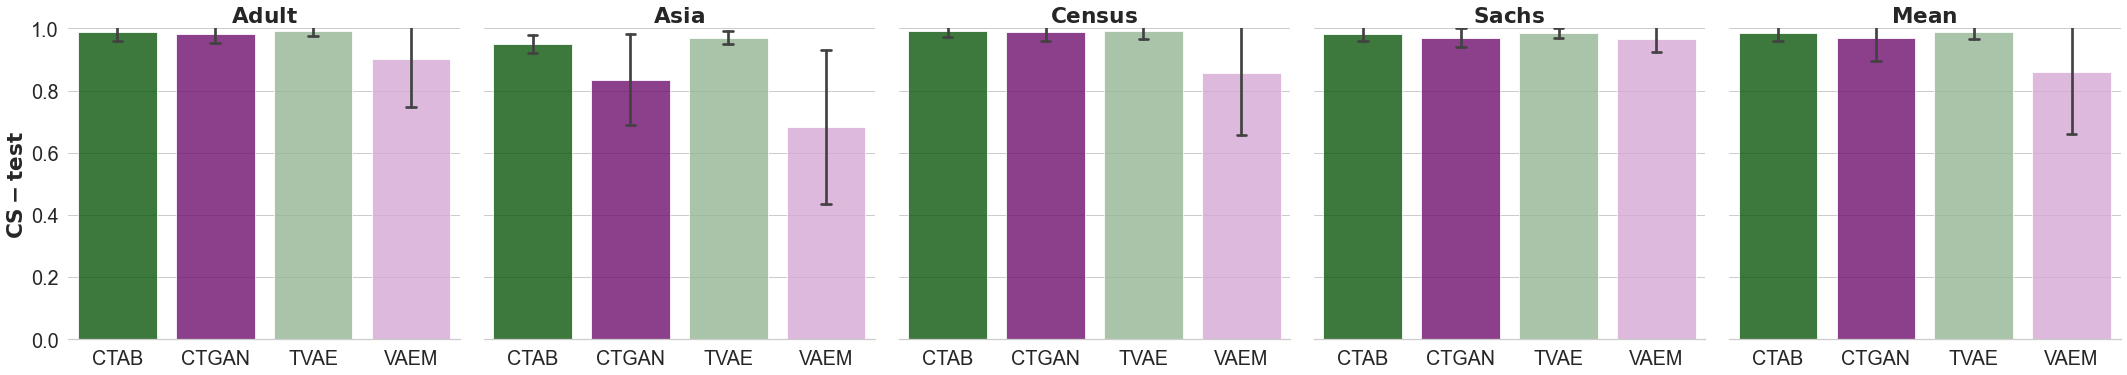

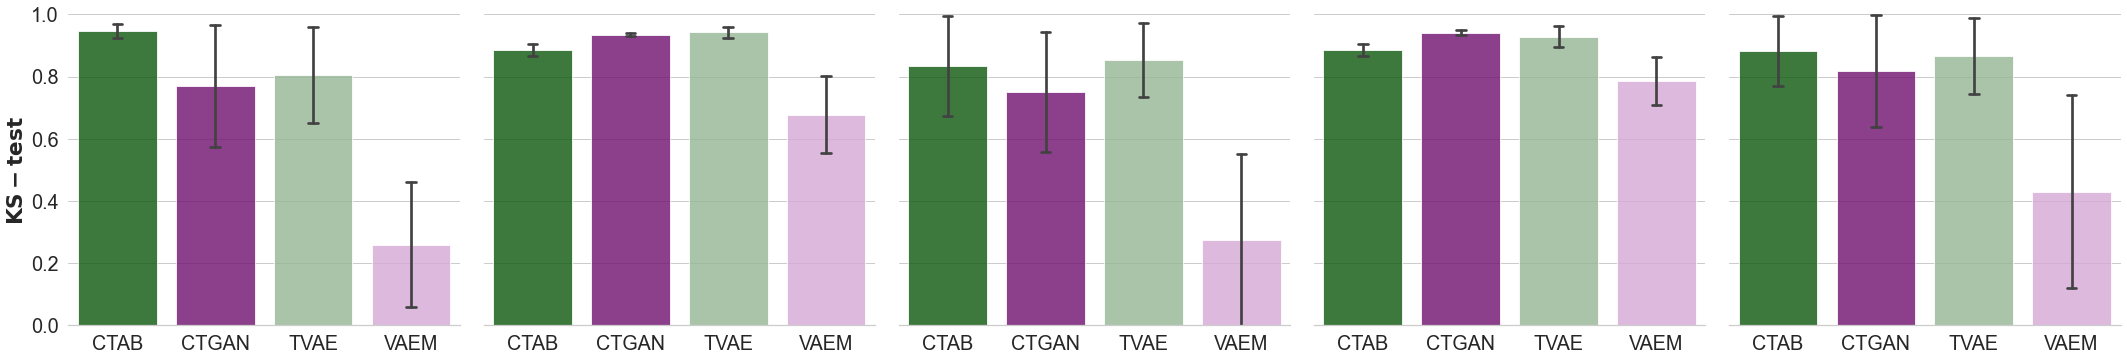

In [7]:
### Make df with columns = [Dataset, Test, Model, Value]:
sns.set_theme(style="whitegrid", font_scale=1.8)
df = pd.DataFrame()
for db in datasets:    
    for mod in models:
        res = pd.read_csv("./Univ_stat_tests/univ_stat_tests_"+db+"_"+mod+exp_suffix+".csv")
        for i,row in res.iterrows():
            temp=[]
            stat = row["Statistic"].split("-")[0]
            temp = pd.Series([db, stat, mod.upper(), row["Mean value"]])
            df = df.append(temp, ignore_index=True)
            # add row again but dataset = Mean to get additional bars for mean. Call it zMean to put it at the end
            temp2 = pd.Series(["zMean", stat, mod.upper(), row["Mean value"]]) 
            df = df.append(temp2, ignore_index=True)
cols=["Dataset", "Test", "Model", "Value"]
df.columns=cols

df = df.sort_values(by=["Dataset", "Test", "Model"])
df=df.reset_index(drop=True)
# rename zMean to Mean:
df['Dataset'] = df['Dataset'].replace(['zMean'],'Mean')
df.to_csv("./Univ_stat_tests/combined_table"+exp_suffix+".csv", index=False)

### Make one plot of CS and one for KS results:
fig = plt.figure()

ax1 = fig.add_subplot(121)
g = sns.catplot(
    data=df[df["Test"]=="CS"], kind="bar",
    x="Model", y="Value", col="Dataset",  ci="sd", 
    palette=["darkgreen", "purple", "darkseagreen", "plum"], alpha=0.8, height=6, capsize=0.1,
)
g.despine(left=True)
g.set_axis_labels("", "$\\bf{}$".format("CS-test"))
g.set(ylim=(0, 1))
g.set_titles("$\\bf{col_name}$")

g.figure.savefig("../Evaluation/Univ_stat_tests/barchart_per_db_CS"+exp_suffix+".png")


ax2 = fig.add_subplot(122)
g = sns.catplot(
    data=df[df["Test"]=="KS"], kind="bar", #col_wrap=2,
    x="Model", y="Value", col="Dataset", ci="sd", 
    palette=["darkgreen", "purple", "darkseagreen", "plum"], alpha=0.8, height=6, capsize=0.1,
)
g.despine(left=True)
g.set_axis_labels("", "$\\bf{}$".format("KS-test"))
g.set(ylim=(0, 1))
g.set_titles("")

g.figure.savefig("../Evaluation/Univ_stat_tests/barchart_per_db_KS"+exp_suffix+".png")

plt.close(1) # close empty figure 2 created by first catplot


## Combine multivariate metrics
***Association matrix difference***

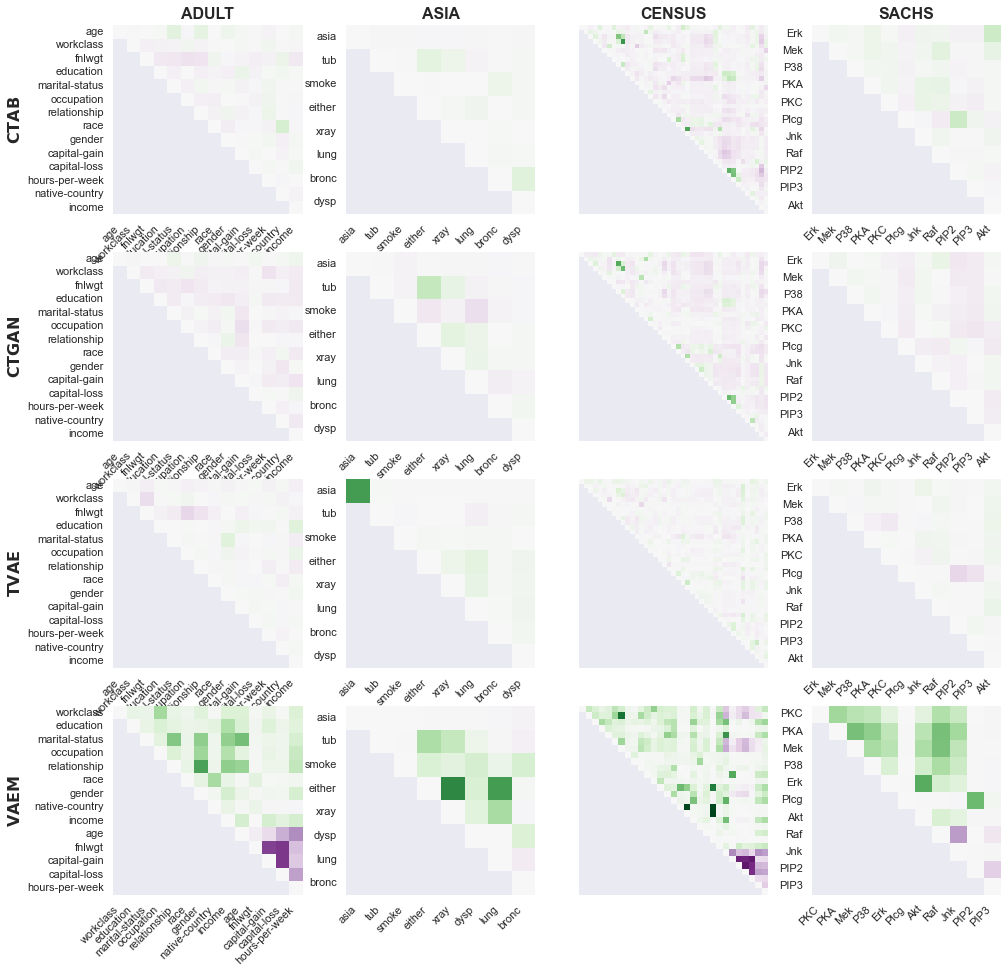

In [24]:
sns.set_theme(style="whitegrid")
sns.set(rc= {"figure.figsize": (4*len(datasets),4*len(models))})
fig, axs = plt.subplots(len(models), len(datasets))

# make multi-index row indexes:
midx=[]
for m in models:
    midx.append((m.upper(), "Max"))
    midx.append((m.upper(), "Pos_RMSE"))
    midx.append((m.upper(), "Neg_RMSE"))
    midx.append((m.upper(), "Min"))
midx = pd.MultiIndex.from_tuples(midx)

df = pd.DataFrame(np.zeros((len(models)*4, len(datasets))), columns = datasets, index = midx)

for i in range(len(models)):
    for j in range(len(datasets)):
        diff = pd.read_csv("../Evaluation/Association_matrix/assoc_mtx_"+datasets[j]+"_"+models[i]+exp_suffix+"_diff.csv", index_col=0)
        # make into upper triangular mtx:
        diff = diff.where(np.triu(np.ones(diff.shape)).astype(np.bool))
        # compute min, max, pos & neg RMSE of diff mtx:
        pos=[]
        neg=[]
        max_v=0
        min_v=0
        for lst in diff.values:
            for v in lst:
                if v>0:
                    pos.append(v)
                    if v>max_v:
                        max_v=v
                elif v<0:
                    neg.append(v)
                    if v<min_v:
                        min_v=v
        pos_rmse = round(sqrt(mean([x**2 for x in pos])),3)
        neg_rmse = round(sqrt(mean([x**2 for x in neg])),3)
        df[datasets[j]].loc[models[i].upper()]=[max_v.round(3), pos_rmse, neg_rmse, min_v.round(3)]

        if j==2: # Census dataset -> no axis labels:
            g = sns.heatmap(diff, vmin=-1, vmax=1, center=0,cmap="PRGn", square=True, ax = axs[i,j], cbar=False, yticklabels=False, xticklabels=False)
        else:
            g = sns.heatmap(diff, vmin=-1, vmax=1, center=0,cmap="PRGn", square=True, ax = axs[i,j], cbar=False)
        axs[i,j].set_xticklabels(axs[i,j].get_xticklabels(), rotation=45, horizontalalignment='right')

        if j==0: # add model label to plots in first column
            g.set_ylabel("$\\bf{}$".format(models[i].upper()), fontsize=16)
        
        if i==0: # add dataset label to plots in first
            #g.set(title="$\\bf{}$".format(datasets[j].upper()))
            axs[i,j].set_title(datasets[j].upper(),fontweight="bold", size=16) 
            
df.to_csv("../Evaluation/Association_matrix/assoc_mtx"+exp_suffix+"_diff_summmary.csv", index=False)
fig.figure.savefig("../Evaluation/Association_matrix/assoc_mtx"+exp_suffix+"_combined_diff.png")

In [135]:
df

Adult   Asia  Census  Sachs
CTAB  Max       0.208  0.151   0.692  0.252
      Pos_RMSE  0.056  0.056   0.134  0.085
      Neg_RMSE  0.041  0.014   0.071  0.031
      Min      -0.123 -0.027  -0.313 -0.063
CTGAN Max       0.080  0.275   0.614  0.086
      Pos_RMSE  0.036  0.109   0.121  0.033
      Neg_RMSE  0.057  0.045   0.061  0.056
      Min      -0.137 -0.135  -0.174 -0.096
TVAE  Max       0.155  0.667   0.250  0.080
      Pos_RMSE  0.044  0.156   0.063  0.042
      Neg_RMSE  0.046  0.018   0.034  0.045
      Min      -0.181 -0.049  -0.174 -0.182
VAEM  Max       0.644  0.740   0.999  0.607
      Pos_RMSE  0.211  0.298   0.211  0.327
      Neg_RMSE  0.430  0.027   0.299  0.106
      Min      -0.764 -0.065  -0.889 -0.432

***Real association matrix***

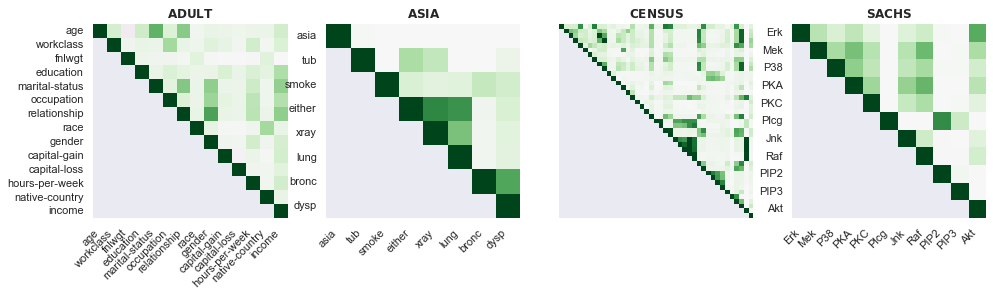

In [128]:
sns.set(rc= {"figure.figsize": (4*len(datasets),4)})
fig, axs = plt.subplots(1, len(datasets))

for j in range(len(datasets)):
    real = pd.read_csv("../Evaluation/Association_matrix/assoc_mtx_"+datasets[j]+"_ctab"+exp_suffix+"_real.csv", index_col=0)
    # make into upper triangular mtx:
    real = real.where(np.triu(np.ones(real.shape)).astype(np.bool))
    
    n_feat = diff.shape[0]
    if j==2: # Census dataset -> no axis labels:
        g = sns.heatmap(real, vmin=-1, vmax=1, center=0,cmap="PRGn", square=True, ax = axs[j], cbar=False, yticklabels=False, xticklabels=False)
    else:
        g = sns.heatmap(real, vmin=-1, vmax=1, center=0,cmap="PRGn", square=True, ax = axs[j], cbar=False)
    axs[j].set_xticklabels(axs[j].get_xticklabels(), rotation=45, horizontalalignment='right')
    
    g.set(title="$\\bf{}$".format(datasets[j].upper()))
fig.figure.savefig("../Evaluation/Association_matrix/assoc_mtx_real.png")

***Dimension-wise prediction***

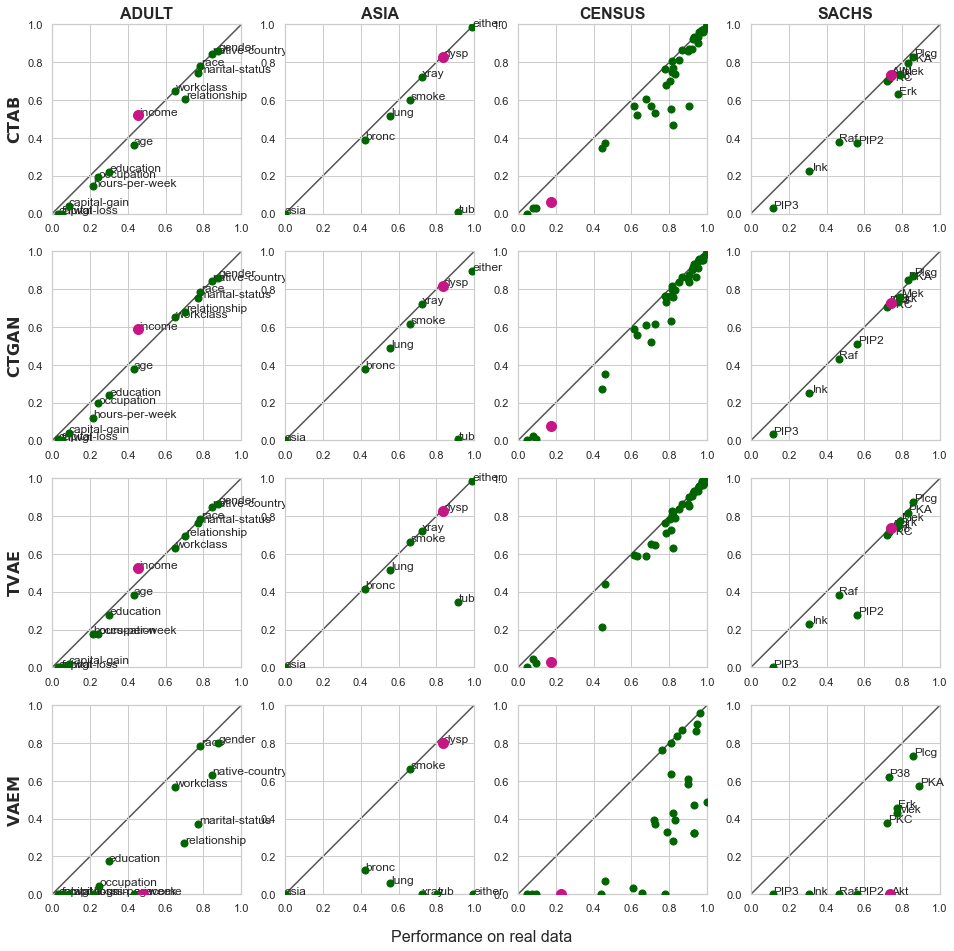

In [28]:
sns.set(rc= {"figure.figsize": (4*len(datasets), 4*len(models))})
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(len(models), len(datasets))
lims = [0,1]

for i in range(len(models)):
    for j in range(len(datasets)):
        df = pd.read_csv("../Evaluation/Dim_wise_pred/dwp_"+datasets[j]+"_"+models[i]+exp_suffix+".csv")
        
        dataset_name = datasets[j]
        if dataset_name in ["Adult", "Census"]:
            real_file_root = "../Real_Datasets/"
        else:
            real_file_root = "../BN_Datasets/"
        with open(real_file_root+ dataset_name+"/"+dataset_name+"_meta.json") as json_file:
            meta = json.load(json_file)
        target = meta["target"]
    
        axs[i,j].scatter(df["Real_score"], df["Mean_fake_score"], c="darkgreen", s=50, zorder=10)
        # plot original target feature y in violet:
        axs[i,j].scatter(df[df["Target feature"]==target]["Real_score"], df[df["Target feature"]==target]["Mean_fake_score"], c="mediumvioletred", s=100, zorder=10)
        # plot both limits against eachother to get y=x line
        axs[i,j].plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        axs[i,j].set_aspect('equal')
        axs[i,j].set_xlim(lims)
        axs[i,j].set_ylim(lims)
        if j!=2: # not the Census set:
            for k, txt in enumerate(list(df["Target feature"])):
                axs[i,j].annotate(txt, (list(df["Real_score"])[k], list(df["Mean_fake_score"])[k]), xycoords='data', textcoords='offset points')
        if j==0:
            axs[i,j].set_ylabel("$\\bf{}$".format(models[i].upper()), fontsize=16)
        if i==0:
            axs[i,j].set_title(datasets[j].upper(),fontweight="bold", size=16) 
fig.suptitle("Performance on real data", y=0.095, fontsize=16)
fig.figure.savefig("../Evaluation/Dim_wise_pred/dwp"+exp_suffix+"_combined.png")

***Within data NNDR***

In [97]:
# Combine F&F and R&R pr_ch data from different datasets:  cols=["Dataset", "Model", "Type (F&F, R&R)", "DCR", "NNDR"]
#datasets= ["Adult", "Asia", "Sachs2"]
ff_df = pd.DataFrame()
for db in datasets:    
    for mod in models:
        res = pd.read_csv("./Privacy_checks/pr_ch_"+db+"_"+mod+exp_suffix+"_raw.csv")
        #print("For", db, "with", mod, "size:", res.shape)
        # drop rows with F&R values:
        res = res.drop(res[res["Type"]=="F&R"].index)
        # only keep R&R results for CTAB model as data is same for all models so only need it once
        if mod != "ctab": 
            res = res.drop(res[res["Type"]=="R&R"].index) 
        temp = pd.DataFrame(data={"Dataset": res["Dataset"], "Model": mod.upper(), "Type": res["Type"], "DCR":res["DCR"], "NNDR":res["NNDR"]})
        ff_df = ff_df.append(temp, ignore_index=True)
        # add row again but dataset = Mean to get additional bars for mean - call it zMean to put it at the end
        temp2 = pd.DataFrame(data={"Dataset": "zMean", "Model": mod.upper(), "Type": res["Type"], "DCR":res["DCR"], "NNDR":res["NNDR"]})
        ff_df = ff_df.append(temp2, ignore_index=True)
# rename Model = CTAB to R&R as these rows are not model-specific (needed for barchart later):
ff_df.loc[(ff_df.Type=="R&R"), "Model"] = "zR&R"

ff_df = ff_df.sort_values(by=["Dataset", "Model", "Type"])
ff_df=ff_df.reset_index(drop=True)
# rename zMean to Mean & zR&R to R&R after sorting (so they come last):
ff_df['Dataset'] = ff_df['Dataset'].replace(['zMean'],'Mean')
ff_df['Model'] = ff_df['Model'].replace(['zR&R'],str("within $\\bf{}$".format("Real")))

ff_df.to_csv("./Privacy_checks/combined_type_and_mod_FF"+exp_suffix+".csv", index=False)
ff_df.shape

(589402, 5)

In [3]:
ff_df = pd.read_csv("./Privacy_checks/combined_type_and_mod_FF"+exp_suffix+".csv")
ff_df.head()

,Dataset,Model,Type,DCR,NNDR
0,Adult,CTAB,F&F,0.824135,0.733481
1,Adult,CTAB,F&F,0.941282,0.977694
2,Adult,CTAB,F&F,0.667330,0.779424
3,Adult,CTAB,F&F,1.568503,0.963123
4,Adult,CTAB,F&F,0.510368,0.447506


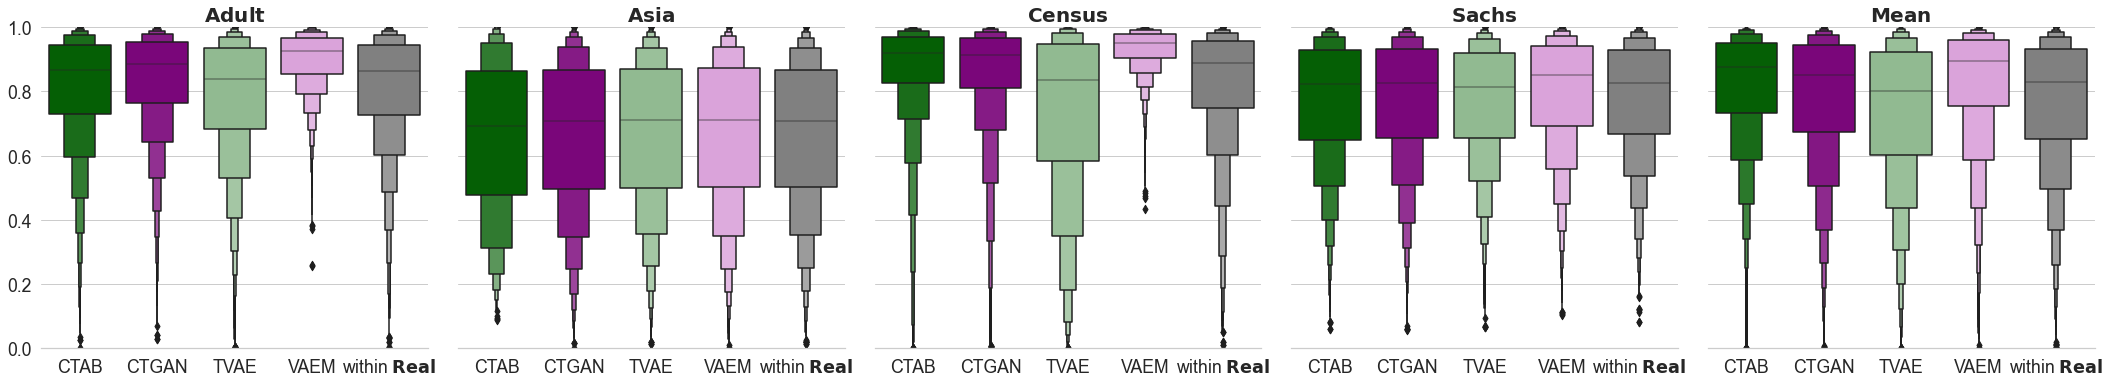

In [4]:
# BOXENPLOT:
sns.set_theme(style="whitegrid", font_scale=1.6)
g = sns.catplot(
    data=ff_df, kind="boxen", #col_wrap=2,
    x="Model", y="NNDR", col="Dataset",  ci="sd", 
    palette=["darkgreen", "purple", "darkseagreen", "plum", "grey"], height=6, saturation = 0.9,
)
g.despine(left=True)
#g.set_axis_labels("", "Within data $\\bf{}$".format("NNDR"), fontsize=20)
g.set_axis_labels("", "")
g.set(ylim=(0, 1))
g.set_titles("$\\bf{col_name}$", size=20)

g.figure.savefig("../Evaluation/Privacy_checks/NNDR_FF_boxplot"+exp_suffix+".png")

## Privacy checks

***DCR***

In [154]:
# Combine F&R pr_ch data from different datasets:  cols=["Dataset", "Model", "DCR", "NNDR"]
fr_df = pd.DataFrame()
for db in datasets:    
    for mod in models:
        res = pd.read_csv("./Privacy_checks/pr_ch_"+db+"_"+mod+exp_suffix+"_raw.csv")
        # drop rows with F&F values:
        res = res.drop(res[res["Type"]=="F&F"].index)
        # drop rows with R&R values:
        res = res.drop(res[res["Type"]=="R&R"].index)
        # only keep R&R results for CTAB model as data is same for all models so only need it once
        #if mod != "ctab": 
        #    res = res.drop(res[res["Type"]=="R&R"].index) 
        temp = pd.DataFrame(data={"Dataset": res["Dataset"], "Model": mod.upper(), "DCR":res["DCR"], "NNDR":res["NNDR"]})
        fr_df = fr_df.append(temp, ignore_index=True)
        # add row again but dataset = Mean to get additional bars for mean - call it zMean to put it at the end
        temp2 = pd.DataFrame(data={"Dataset": "zMean", "Model": mod.upper(), "DCR":res["DCR"], "NNDR":res["NNDR"]})
        fr_df = fr_df.append(temp2, ignore_index=True)

fr_df = fr_df.sort_values(by=["Dataset", "Model"])
fr_df=fr_df.reset_index(drop=True)
# rename zMean to Mean after sorting (so they come last):
fr_df['Dataset'] = fr_df['Dataset'].replace(['zMean'],'Mean')

fr_df.to_csv("./Privacy_checks/combined_type_and_mod_FR"+exp_suffix+".csv", index=False)
fr_df.shape

(640272, 4)

In [35]:
fr_df = pd.read_csv("./Privacy_checks/combined_type_and_mod_FR"+exp_suffix+".csv")
fr_df.head()

,Dataset,Model,DCR,NNDR
0,Adult,CTAB,1.116041,0.852764
1,Adult,CTAB,1.016528,0.807750
2,Adult,CTAB,0.452169,0.590940
3,Adult,CTAB,1.497445,0.617219
4,Adult,CTAB,0.980757,0.953836


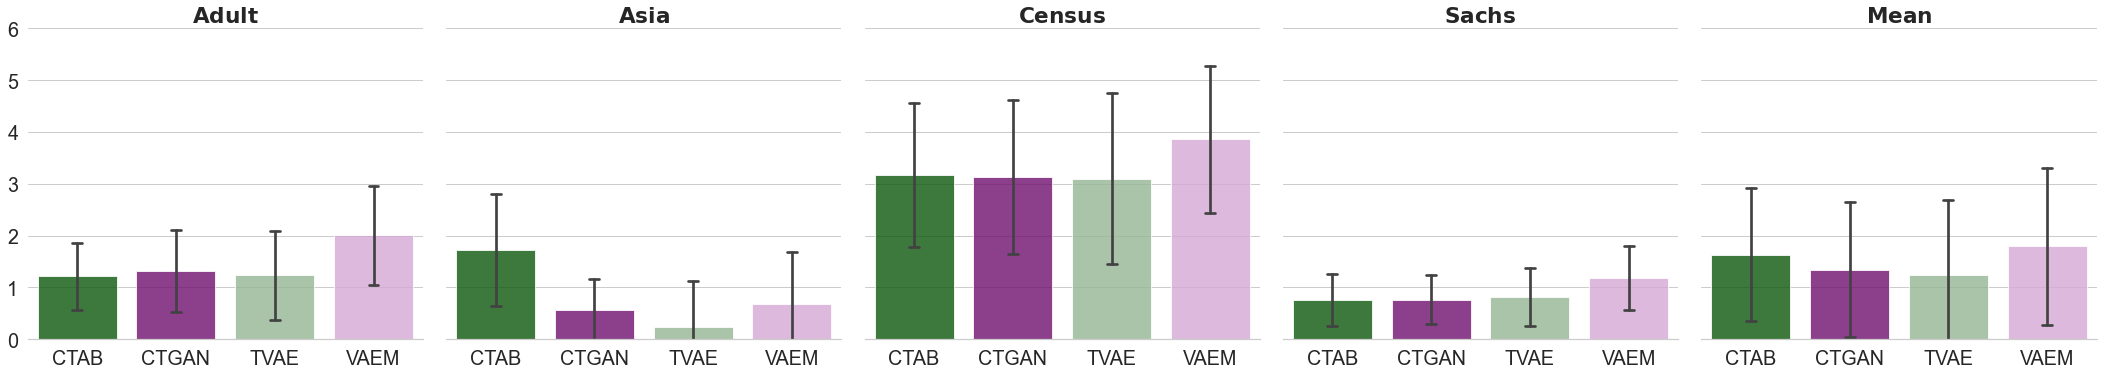

In [44]:
# BARCHART:
sns.set_theme(style="whitegrid", font_scale=1.8)
g = sns.catplot(
    data=fr_df, kind="bar", #col_wrap=2,
    x="Model", y="DCR", col="Dataset",  ci="sd", 
    palette=["darkgreen", "purple", "darkseagreen", "plum"], height=6, alpha=0.8, capsize=0.1,
)
g.despine(left=True)
g.set_axis_labels("", "")
g.set(ylim=(0, 6))
g.set_titles("$\\bf{col_name}$")

g.figure.savefig("../Evaluation/Privacy_checks/DCR_FR_barchart"+exp_suffix+".png")

***Between data NNDR***

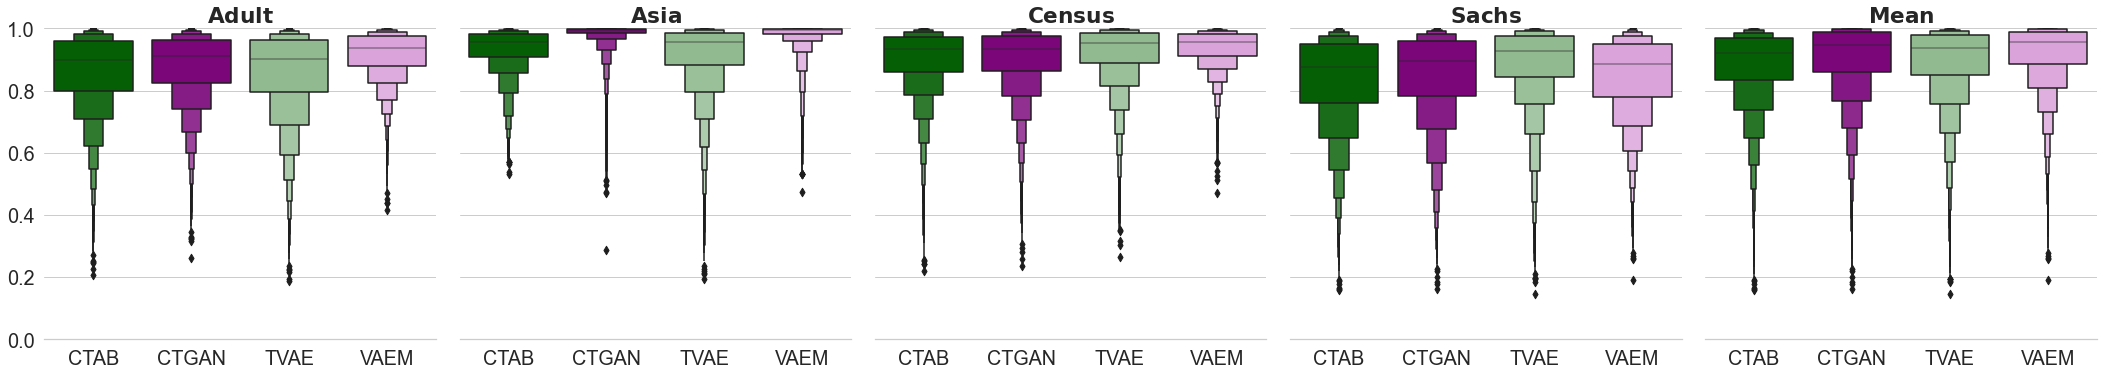

In [45]:
# BOXENPLOT:
sns.set_theme(style="whitegrid", font_scale=1.8)
g = sns.catplot(
    data=fr_df, kind="boxen", #col_wrap=2,
    x="Model", y="NNDR", col="Dataset",  ci="sd", 
    palette=["darkgreen", "purple", "darkseagreen", "plum"], height=6, saturation = 0.9, #ax=axs[0] #, order = datasets+["Mean"]
)
g.despine(left=True)
#g.set_axis_labels("", "Between data $\\bf{}$".format("NNDR"))
g.set_axis_labels("", "")
g.set(ylim=(0, 1))
g.set_titles("$\\bf{col_name}$")

g.figure.savefig("../Evaluation/Privacy_checks/NNDR_FR_boxplot"+exp_suffix+".png")

## Summarise computation times
in minutes

In [4]:
times = pd.DataFrame(np.zeros((len(models), len(datasets))), columns=datasets, index=[m.upper() for m in models])

for mod in models:
    for db in datasets:
        t = pd.read_csv("../Evaluation/Comp_time/final-AWS/times_"+db+"_"+mod+exp_suffix+".csv")
        #print(t)
        # for each model & db, give mean over 3 experiments (in minutes):
        mean = round(t["Comp.times"].mean()/60,3)
        #print(t)
        times.at[mod.upper(), db] = mean
times

,Adult,Asia,Census,Sachs
CTAB,91.976,60.085,260.342,59.431
CTGAN,8.731,6.352,16.746,7.463
TVAE,4.510,3.008,6.777,3.867
VAEM,5.902,2.492,12.114,3.120


In [167]:
# Compare 10 epoch times of HP with AWS:
# make multi-index row indexes:
midx=[]
for m in models:
    midx.append((m.upper(), "HP (CPU)"))
    midx.append((m.upper(), "AWS (GPU)"))
    midx.append((m.upper(), "Factor"))
midx = pd.MultiIndex.from_tuples(midx)

df = pd.DataFrame(np.zeros((len(models)*3, len(datasets))), columns = datasets, index = midx)

for mod in models:
    for db in datasets:
        aws = pd.read_csv("../Evaluation/Comp_time/final-AWS/times_"+db+"_"+mod+exp_suffix+".csv")
        mean_aws = round(aws["Comp.times"].mean()/60,3)
        hp =  pd.read_csv("../Evaluation/Comp_time/times_"+db+"_"+mod+exp_suffix+".csv")
        mean_hp = round(hp["Comp.times"].mean()/60,3)
        factor = round(mean_hp/mean_aws,1)
        df[db].loc[mod.upper()]=[mean_hp, mean_aws, factor]
df

Adult    Asia   Census   Sachs
CTAB  HP (CPU)   101.654  38.897  294.411  39.917
      AWS (GPU)    3.476   2.109    8.975   2.268
      Factor      29.200  18.400   32.800  17.600
CTGAN HP (CPU)     2.202   1.252   10.644   1.489
      AWS (GPU)    1.056   0.535    1.549   0.833
      Factor       2.100   2.300    6.900   1.800
TVAE  HP (CPU)     0.910   0.455    3.964   0.668
      AWS (GPU)    0.889   0.392    1.209   0.713
      Factor       1.000   1.200    3.300   0.900
VAEM  HP (CPU)     3.566   1.099    8.998   1.533
      AWS (GPU)    1.503   0.817    4.762   1.081
      Factor       2.400   1.300    1.900   1.400